In [102]:
import numpy as np
import matplotlib.pyplot as plt
import RNG.Distributions as dst
import math
import networkx as nx
import scipy.stats as sstats

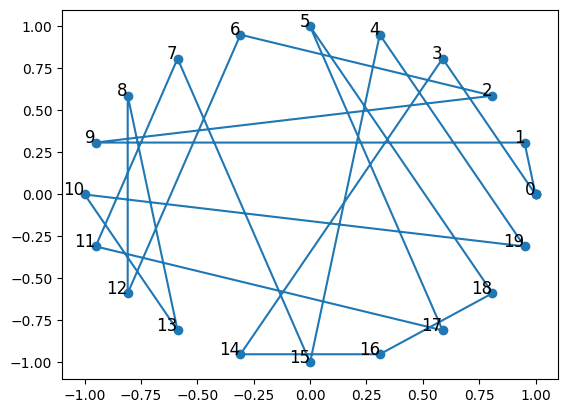

In [124]:
COST_MATRIX = np.array([0,225,110,8,257,22,83,231,277,243,94,30,4,265,274,250,87,83,271,86,
255,0,265,248,103,280,236,91,3,87,274,265,236,8,24,95,247,259,28,259,
87,236,0,95,248,110,25,274,250,271,9,244,83,250,248,280,29,26,239,7,
8,280,83,0,236,28,91,239,280,259,103,23,6,280,244,259,95,87,230,84,
268,87,239,271,0,244,275,9,84,25,244,239,275,83,110,24,274,280,84,274,
21,265,99,29,259,0,99,230,265,271,87,5,22,239,236,250,87,95,271,91,
95,236,28,91,247,93,0,247,259,244,27,91,87,268,275,280,7,8,240,27,
280,83,250,261,4,239,230,0,103,24,239,261,271,95,87,21,274,255,110,280,
247,9,280,274,84,255,259,99,0,87,255,274,280,3,27,83,259,244,28,274,
230,103,268,275,23,244,264,28,83,0,268,275,261,91,95,8,277,261,84,247,
87,239,9,103,261,110,29,255,239,261,0,259,84,239,261,242,24,25,242,5,
30,255,95,30,247,4,87,274,242,255,99,0,24,280,274,259,91,83,247,91,
8,261,83,6,255,29,103,261,247,242,110,29,0,261,244,230,87,84,280,100,
242,8,259,280,99,242,244,99,3,84,280,236,259,0,27,95,274,261,24,268,
274,22,250,236,83,261,247,103,22,91,250,236,261,25,0,103,255,261,5,247,
244,91,261,255,28,236,261,29,103,9,242,261,244,87,110,0,242,236,95,259,
84,236,27,99,230,83,7,259,230,230,22,87,93,250,255,247,0,9,259,24,
91,242,28,87,250,110,6,271,271,255,27,103,84,250,271,244,5,0,271,29,
261,24,250,271,84,255,261,87,28,110,250,248,248,22,3,103,271,248,0,236,
103,271,8,91,255,91,21,271,236,271,7,250,83,247,250,271,22,27,248,0]).reshape(20,20)

def show_cost_mat_path(path):
    G = nx.DiGraph()

    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        G.add_edge(u, v, weight=COST_MATRIX[u, v])

    pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', arrowsize=20)

    edge_labels = {(u, v): f'{G[u][v]["weight"]}' for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.title('Cost path')
    plt.show()

def initialize_route(n_cities):
    route = np.zeros(n_cities+1,dtype=np.int64)
    route[1:-1] = np.random.permutation(np.arange(1,n_cities))
    return route

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def get_cost(route,positions,i,j,cost_type:str='euclidean'):
    if cost_type == 'euclidean':
        return euclidean_distance(positions[route[i]],positions[route[j]])
    elif cost_type == 'cost_matrix':
        return COST_MATRIX[route[i],route[j]]

def total_distance(route,cost_matrix):
    distance = 0
    n = len(route)
    for i in range(n-1):
        distance += cost_matrix[route[i],route[i+1]]
    return distance

def plot_route(route, positions):
    route_positions = positions[route]
    route_positions = np.vstack([route_positions, route_positions[0]])
    plt.plot(route_positions[:, 0], route_positions[:, 1], 'o-')
    for idx, position in enumerate(positions):
        plt.text(position[0], position[1], str(idx), fontsize=12, ha='right')
    plt.show()

def simulated_annealing(positions,current_route, temperature_scheme, max_iterations,cost_matrix):
    n_stations = len(current_route)
    best_route = np.copy(current_route)
    current_distance = total_distance(current_route,cost_matrix)
    best_distance = current_distance
    distance_matrix = np.zeros(max_iterations)

    for k in range(max_iterations):
        # swap two random cities
        i, j = np.random.choice(range(1,n_stations-1), size=2, replace=False)
        #i, j = np.random.choice(n_stations, size=2, replace=False)

        # proposal rpute
        new_route = np.copy(current_route)
        new_route[i], new_route[j] = new_route[j], new_route[i]

        # compute distances
        current_distance = total_distance(current_route,cost_matrix)
        new_distance = total_distance(new_route,cost_matrix)

        # decide whether to accept the new route
        t = temperature_scheme(k) # get temperature
        p_i = np.exp((current_distance - new_distance) / t)

        if new_distance < current_distance or np.random.rand() < p_i:
            current_route = new_route
            current_distance = new_distance

        # save best route if it is has the lowest distance
        if new_distance < best_distance:
            best_route = new_route
            best_distance = new_distance

        distance_matrix[k] = current_distance

    return best_route, best_distance,distance_matrix

def temperature_scheme_1(k):
    return 1 / np.sqrt(1 + k)

def temperature_scheme_2(k):
    return -np.log(k + 1)

def generate_circle_positions(n_stations, radius=1):
    angles = np.linspace(0, 2 * np.pi, n_stations, endpoint=False)
    return np.array([[radius * np.cos(angle), radius * np.sin(angle)] for angle in angles])


n_cities = 20
circle_positions = generate_circle_positions(n_cities, radius=1)
circle_route = initialize_route(n_cities)
plot_route(circle_route, circle_positions)


# Exercise 7 - Task 1)

We found that the original sqrt based temperature scheme was too greedy. It tried too quickly to converge to a sub-optimal solution.

So we decided to make it decrease the temperature much more slowly, thereby allowing it to explore more, by multiplying it with a constant of 100.

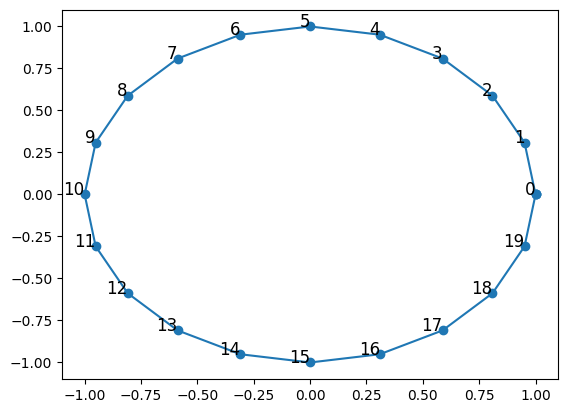

6.257378601609234


In [125]:
diff = circle_positions[:, np.newaxis, :] - circle_positions[np.newaxis, :, :]

# Calculate pairwise distances
distance_matrix = np.sqrt(np.sum(diff**2, axis=-1)) #The distance between them
T = lambda k: 100/(np.sqrt(1+k))
best_route,best_distance,distance_record = simulated_annealing(circle_positions,circle_route,T,100000,distance_matrix)
plot_route(best_route,circle_positions)
print(best_distance)

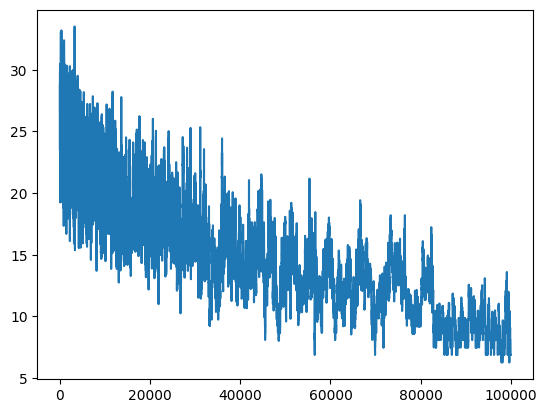

In [126]:
distance_record100 = distance_record
plt.plot(distance_record100)

# Exercise 7 - Task 2

We decided to increase the constant, so it would converge more slowly, as it quickly converged to a sub-optimal.

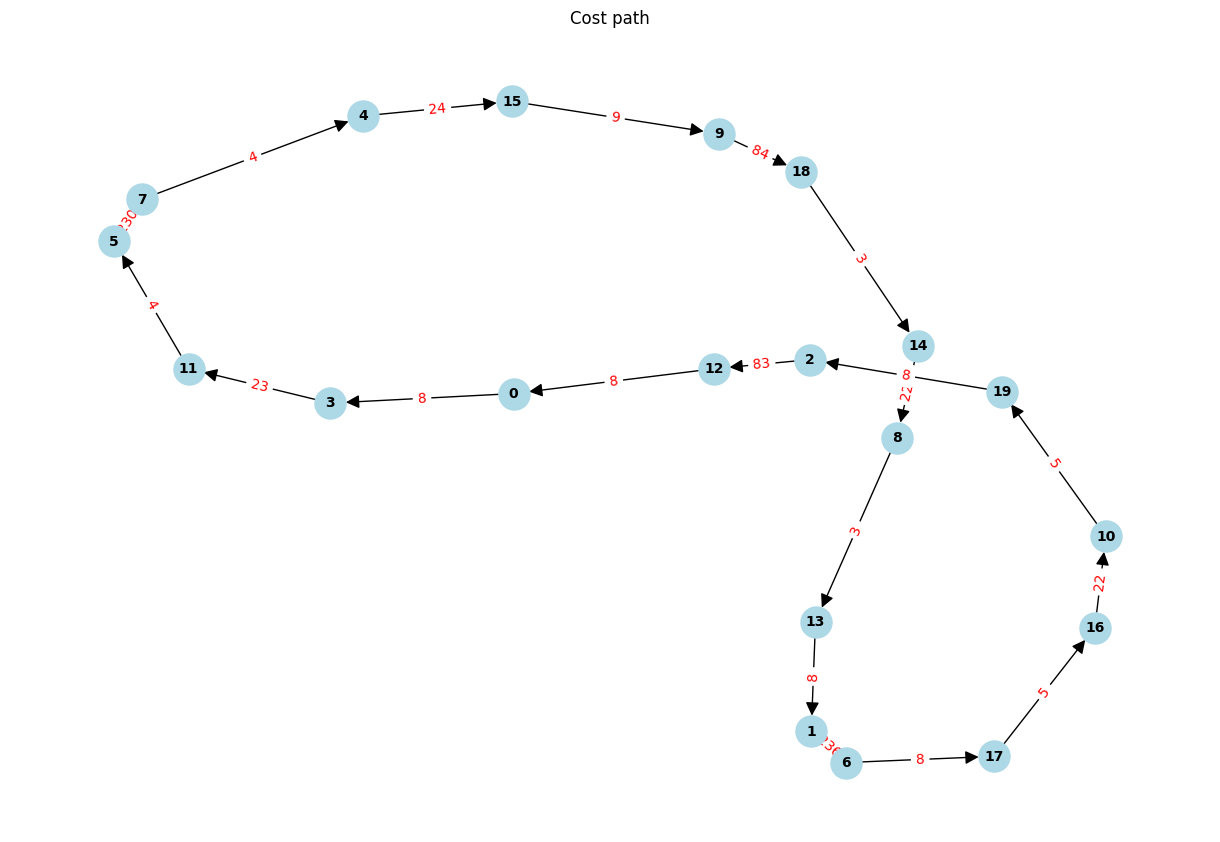

797

In [109]:
diff = circle_positions[:, np.newaxis, :] - circle_positions[np.newaxis, :, :]

# Calculate pairwise distances
X = np.sqrt(np.sum(diff**2, axis=-1))
T = lambda k: 10000/(np.sqrt(1+k))
best_route,best_distance,distance_record = simulated_annealing(circle_positions,circle_route,T,1000000,COST_MATRIX)
show_cost_mat_path(best_route)
best_distance

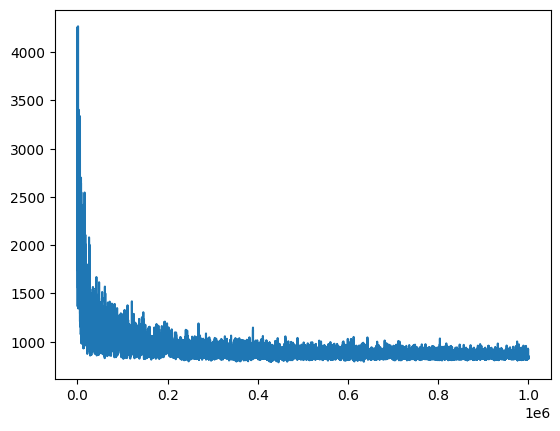

In [107]:
plt.plot(distance_record)

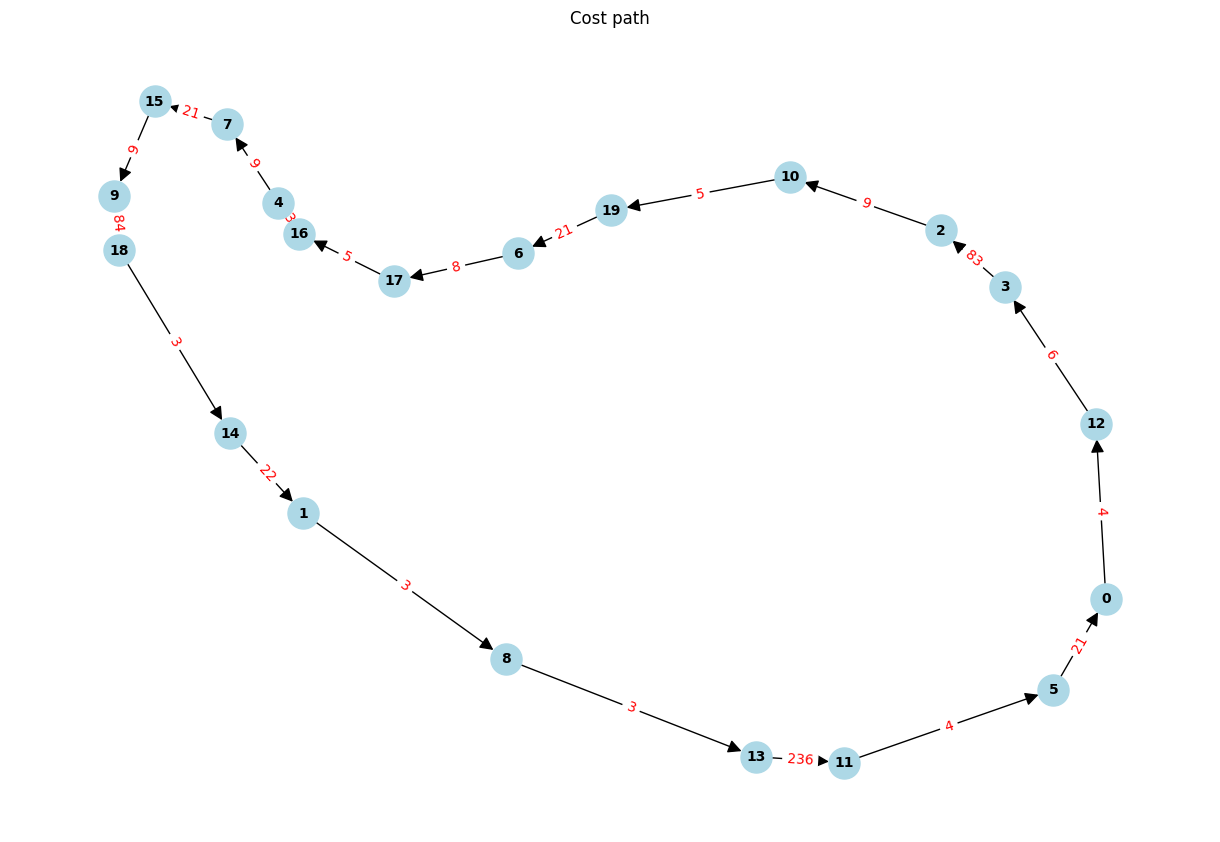

In [108]:
show_cost_mat_path(best_route)